### Setup Environment

In [1]:
Project_Root = '/gdrive/MyDrive/CV_Project/'

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd -q $Project_Root

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
!ls

checkpoints   documents      __pycache__       train.ipynb	vqvae.py
data	      GetData.ipynb  README.md	       utils.py
decompose.py  images	     requirements.txt  visualize.ipynb


In [4]:
!pip install -r requirements.txt --upgrade

### Visualize Data

In [5]:
!ls

checkpoints   documents      __pycache__       train.ipynb	vqvae.py
data	      GetData.ipynb  README.md	       utils.py
decompose.py  images	     requirements.txt  visualize.ipynb


In [6]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [7]:
data_dir = './data'

In [8]:
BATCH_SIZE = 64
transform = torchvision.transforms.ToTensor()

mnist_trainset = datasets.MNIST(root=data_dir, train=True, download=False, transform=transform)
train_data_variance = torch.Tensor.var(mnist_trainset.data / 255)
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(len(mnist_trainset))

mnist_testset = datasets.MNIST(root=data_dir, train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(len(mnist_testset))

60000
10000


In [9]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

Labels:  tensor([0, 7, 4, 1, 2, 3, 3, 0, 0, 0, 5, 0, 8, 2, 1, 6, 6, 5, 7, 2, 9, 0, 5, 6,
        7, 9, 7, 2, 4, 9, 9, 4, 5, 2, 3, 3, 8, 7, 5, 7, 4, 1, 9, 5, 7, 6, 3, 6,
        7, 3, 0, 8, 7, 5, 4, 0, 6, 5, 4, 9, 8, 3, 8, 0])
Batch shape:  torch.Size([64, 1, 28, 28])


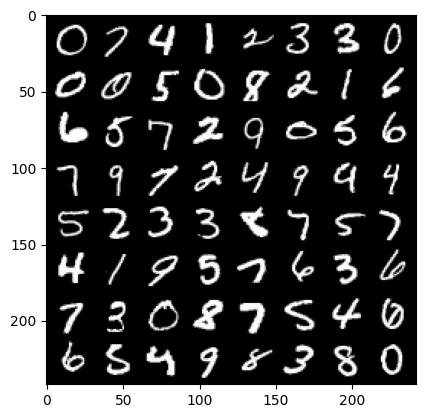

In [10]:
data_iter = iter(trainloader)
images, labels = next(data_iter)
print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

### Hyperparameters

In [11]:
!ls

checkpoints   documents      __pycache__       train.ipynb	vqvae.py
data	      GetData.ipynb  README.md	       utils.py
decompose.py  images	     requirements.txt  visualize.ipynb


In [12]:
from vqvae import VQVAE
from torch import nn, optim
import os
import utils

In [13]:
device = torch.device("cpu")
use_ema = True
epochs = 10
eval_every = 100
save_every = 5
best_train_loss = float("inf")
if not os.path.isdir("checkpoints"):
    os.makedirs("checkpoints")
save_path = "checkpoints/save_2.pth"
resume_train = os.path.isfile(save_path)
lr = 3e-4
model_args = {
    "in_channels": 1,
    "out_channels": 1,
    "num_hiddens": 128,
    "num_downsampling_layers": 2,
    "num_residual_layers": 2,
    "num_residual_hiddens": 32,
    "embedding_dim": 64,
    "num_embeddings": 512,
    "use_ema": use_ema,
    "decay": 0.99,
    "epsilon": 1e-5,
}
beta = 0.25

In [14]:
# Load weights if applicable
if resume_train:
  lr, epoch, model_w, optimizer_w, model_args = load_weights(save_path, map_location=device)

# Initialize model.
model = VQVAE(**model_args).to(device)
train_params = [params for params in model.parameters()]
optimizer = optim.Adam(train_params, lr=lr)
criterion = nn.MSELoss()

if resume_train:
  optimizer = optim.Adam(train_params, lr=lr)
  model.load_state_dict(model_w)
  optimizer.load_state_dict(optimizer_w)

### Training VAE

In [15]:
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    total_recon_error = 0
    n_train = 0
    for (batch_idx, train_tensors) in enumerate(trainloader):
        optimizer.zero_grad()
        imgs = train_tensors[0].to(device)
        out = model(imgs)
        recon_error = criterion(out["x_recon"], imgs) / train_data_variance
        total_recon_error += recon_error.item()
        loss = recon_error + beta * out["commitment_loss"]
        if not use_ema:
            loss += out["dictionary_loss"]

        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        n_train += 1

        if ((batch_idx + 1) % eval_every) == 0:
            print(f"epoch: {epoch}\nbatch_idx: {batch_idx + 1}", flush=True)
            total_train_loss /= n_train
            if total_train_loss < best_train_loss:
                best_train_loss = total_train_loss
                save_dict = {
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'lr': lr,
                  'model_args': model_args
                }
                ssplit = os.path.splitext(save_path)
                be_save = f"{ssplit[0]}_best{ssplit[1]}"
                torch.save(save_dict, be_save)

            print(f"total_train_loss: {total_train_loss} | best_train_loss: {best_train_loss} | recon_error: {total_recon_error / n_train}\n")

            total_train_loss = 0
            total_recon_error = 0
            n_train = 0

    if(epoch % save_every == 0):
        save_dict = {
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'lr': lr,
          'model_args': model_args
        }
        ssplit = os.path.splitext(save_path)
        ep_save = f"{ssplit[0]}_{epoch}{ssplit[1]}"
        torch.save(save_dict, ep_save)

    # Evaluation
    model.eval()
    total_test_loss = 0
    total_test_recon_error = 0
    n_test = 0
    for (batch_idx, test_tensors) in enumerate(testloader):
        imgs = test_tensors[0].to(device)
        out = model(imgs)
        recon_error = criterion(out["x_recon"], imgs) / train_data_variance
        total_test_recon_error += recon_error.item()
        loss = recon_error + beta * out["commitment_loss"]
        total_test_loss += loss.item()
        n_test += 1
    print(f" total_test_loss: {total_test_loss} | recon_error: {total_test_recon_error / n_test}\n")


epoch: 0
batch_idx: 100
total_train_loss: 0.66510173112154 | best_train_loss: 0.66510173112154 | recon_error: 0.6045240893959999

epoch: 0
batch_idx: 200
total_train_loss: 0.24091051816940307 | best_train_loss: 0.24091051816940307 | recon_error: 0.18508146822452545

epoch: 0
batch_idx: 300
total_train_loss: 0.16033024445176125 | best_train_loss: 0.16033024445176125 | recon_error: 0.12020127542316913

epoch: 0
batch_idx: 400
total_train_loss: 0.13558720149099826 | best_train_loss: 0.13558720149099826 | recon_error: 0.09929576873779297

epoch: 0
batch_idx: 500
total_train_loss: 0.12212280884385109 | best_train_loss: 0.12212280884385109 | recon_error: 0.08736293710768223

epoch: 0
batch_idx: 600
total_train_loss: 0.11150363340973854 | best_train_loss: 0.11150363340973854 | recon_error: 0.07896175712347031

epoch: 0
batch_idx: 700
total_train_loss: 0.10091488160192967 | best_train_loss: 0.10091488160192967 | recon_error: 0.07096424419432878

epoch: 0
batch_idx: 800
total_train_loss: 0.0931

### Evaluation

In [16]:
!ls

checkpoints   documents      __pycache__       train.ipynb	vqvae.py
data	      GetData.ipynb  README.md	       utils.py
decompose.py  images	     requirements.txt  visualize.ipynb


In [24]:
from utils import save_img_tensors_as_grid

image_save_path = "images/"
if not os.path.isdir(image_save_path):
    os.makedirs(image_save_path)

true_file = os.path.join(image_save_path, "true.png")
recon_file = os.path.join(image_save_path, "recon.png")

model.eval()
with torch.no_grad():
    for valid_tensors in testloader:
        break

    save_img_tensors_as_grid(valid_tensors[0], 4, true_file)
    save_img_tensors_as_grid(model(valid_tensors[0].to(device))["x_recon"], 4, recon_file)